# Transport Usage Prediction

**Team Members**:
- Timur Kasatkin
- Sergey Pinkevich

**Team name**: rzd

In [1]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [2]:
import sklearn as skl
import sklearn
import pandas as pd
import scipy
import seaborn as sns

In [3]:
train_df = pd.read_csv(
    "train.csv",
    parse_dates=["date"],
    # dtype={"hour":object,"holiday":bool,"workingday":bool,"weekday":object,"weather_type":object}
    dtype={
        "hour": int8,
        "holiday": bool,
        "workingday": bool,
        "weekday": int8,
        "weather_type": int8
    })
train_df.head()

,date,hour,holiday,workingday,weekday,weather_type,temp,ftemp,humidity,wind_speed,casual,subscribed,usage
0,2011-01-03,0,False,True,1,1,0.22,0.19699999999999998,0.44,0.3582,0,15,15
1,2011-01-03,1,False,True,1,1,0.20,0.1667,0.44,0.4179,0,6,6
2,2011-01-03,4,False,True,1,1,0.16,0.1364,0.47,0.3881,0,3,3
3,2011-01-03,5,False,True,1,1,0.16,0.1364,0.47,0.2836,0,9,9
4,2011-01-03,6,False,True,1,1,0.14,-,0.50,0.3881,0,90,90


In [4]:
print(train_df.pivot_table(values='casual',index='holiday'),\
     train_df.pivot_table(values='subscribed',index='holiday'),\
     train_df.pivot_table(values='usage',index='holiday'),sep='\n')

holiday
False    175.949792
True     206.072829
Name: casual, dtype: float64
holiday
False    461.585134
True     346.218487
Name: subscribed, dtype: float64
holiday
False    637.534926
True     552.291317
Name: usage, dtype: float64


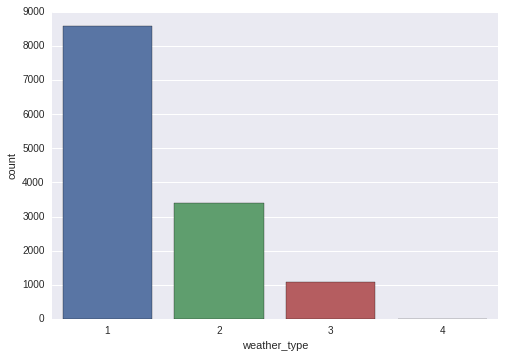

In [5]:
sns.countplot(train_df.weather_type);

# 1. Data investigation

In [6]:
train_df.corr()[:"wind_speed"]

,hour,holiday,workingday,weekday,weather_type,temp,humidity,wind_speed,casual,subscribed,usage
hour,1.000000,0.000468,0.002209,-0.003679,-0.029682,0.131916,-0.271771,0.127540,0.028011,0.371302,0.098023
holiday,0.000468,1.000000,-0.247877,-0.094536,-0.013434,-0.008131,0.006655,-0.019608,0.002130,-0.041417,-0.005842
workingday,0.002209,-0.247877,1.000000,0.036898,0.057356,0.053103,0.025730,-0.004804,-0.015372,0.134013,0.010684
weekday,-0.003679,-0.094536,0.036898,1.000000,0.000816,0.000837,-0.043147,0.025951,-0.000206,0.015390,0.002738
weather_type,-0.029682,-0.013434,0.057356,0.000816,1.000000,-0.083150,0.417010,0.044447,-0.015864,-0.131915,-0.040555
temp,0.131916,-0.008131,0.053103,0.000837,-0.083150,1.000000,-0.032506,-0.035742,0.040763,0.332923,0.103055
humidity,-0.271771,0.006655,0.025730,-0.043147,0.417010,-0.032506,1.000000,-0.282958,-0.036357,-0.268173,-0.086425
wind_speed,0.127540,-0.019608,-0.004804,0.025951,0.044447,-0.035742,-0.282958,1.000000,0.010544,0.080219,0.025531


# 2. Data Preprocessing

### date

In [7]:
from sklearn.preprocessing import MinMaxScaler

In [8]:
date_scaler = MinMaxScaler()
train_df.date = date_scaler.fit_transform(train_df.date.astype(int)[:,newaxis])

/home/timur/dev_ides/anaconda3/lib/python3.5/site-packages/sklearn/utils/validation.py:429: DataConversionWarning: Data with input dtype int64 was converted to float64 by MinMaxScaler.
  warnings.warn(msg, _DataConversionWarning)


In [11]:
assert date_scaler.data_max_ > 1

### ftemp

In [12]:
ftemp_nonna_df = train_df[train_df.ftemp != '-']
ftemp_mean_dif = (ftemp_nonna_df.temp - ftemp_nonna_df.ftemp.astype(float)).mean()

In [13]:
train_df["ftemp_mean_diff"] = train_df.ftemp
train_df.loc[train_df.ftemp == '-', 'ftemp_mean_diff'] = train_df.temp - ftemp_mean_dif
train_df["ftemp_mean_diff"] = train_df.ftemp_mean_diff.astype(float)

In [15]:
train_df = pd.concat([train_df.loc[:,:"ftemp"], train_df.ftemp_mean_diff, train_df.loc[:,"humidity":"usage"]],axis=1)

In [16]:
train_df.head()

,date,hour,holiday,workingday,weekday,weather_type,temp,ftemp,ftemp_mean_diff,humidity,wind_speed,casual,subscribed,usage
0,0.0,0,False,True,1,1,0.22,0.19699999999999998,0.197000,0.44,0.3582,0,15,15
1,0.0,1,False,True,1,1,0.20,0.1667,0.166700,0.44,0.4179,0,6,6
2,0.0,4,False,True,1,1,0.16,0.1364,0.136400,0.47,0.3881,0,3,3
3,0.0,5,False,True,1,1,0.16,0.1364,0.136400,0.47,0.2836,0,9,9
4,0.0,6,False,True,1,1,0.14,-,0.119043,0.50,0.3881,0,90,90


In [ ]:
sns.pairplot(train_df);
savefig('scatter.png',dpi=300)

### Data forming

In [37]:
def extract_train(df, as_matrix=True):
    discrete = df[["hour","holiday","workingday","weekday"]]
    continious = df[["date","temp","ftemp_mean_diff","humidity","wind_speed"]]
    X_train = pd.concat((continious, discrete),axis=1)
    y_subscribed_train = df.subscribed.astype(int)
    y_casual_train = df.casual.astype(int)
    y_usage_train = df.usage.astype(int)
    if as_matrix:
        return X_train.as_matrix(), \
                y_subscribed_train.as_matrix(), \
                y_casual_train.as_matrix(), \
                y_usage_train.as_matrix()
    return X_train, y_subscribed_train, y_casual_train, y_usage_train

In [ ]:
discrete = pd.concat([train_df.hour.astype(int8),\
                      train_df.holiday,\
                      train_df.workingday,\
                      train_df.weekday.astype(int8)
                     ],axis=1)

continious = train_df[["date","temp","ftemp_mean_diff","humidity","wind_speed"]]

X_train = scipy.hstack((continious.as_matrix(),discrete.as_matrix()))

y_subscribed_train = train_df.subscribed
y_casual_train = train_df.casual
y_train = train_df.usage

X_train, y_subscribed_train, y_casual_train, y_usage_train = extract_train(train_df)

### Outliers removal

#### Profit
- removal of working_day = 1 and casual > 1000
- removal of weekday = 3 and casual > 800
- removal of weather_type = 3 and casual > 800
- removal wind_speed > 0.85 

#### Do not help
- removal of weather_type = 4 (there is only 3 such tuples)
- removal of temp < 0.1 and temp > 0.9
- removal of workingday = 1 and casual > 1000

#### Under question
- leave only wind_speed < 0.85

In [ ]:
train_casual_df = train_df[train_df.casual < 1200]

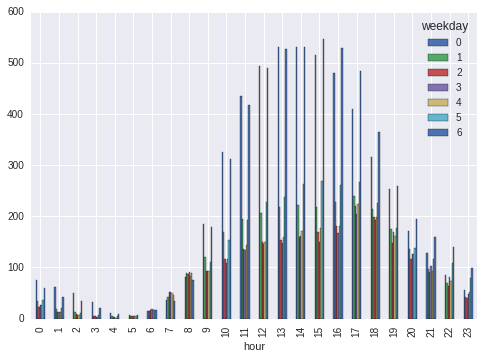

In [62]:
train_casual_df.pivot_table(values='casual', index='hour', columns='weekday', aggfunc=np.mean).plot.bar()

In [ ]:
train_df.pivot_table(values='casual',index='temp').plot()

# 3. Model Tuning

In [18]:
from sklearn.tree import DecisionTreeRegressor
from sklearn.svm import NuSVR,LinearSVR,SVR
from sklearn.neighbors import KNeighborsRegressor
from sklearn.linear_model import SGDRegressor
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor

/home/timur/dev_ides/anaconda3/lib/python3.5/site-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [19]:
from sklearn.metrics import mean_absolute_error,r2_score
from sklearn.model_selection import train_test_split, KFold, GridSearchCV, cross_val_score

In [20]:
def MAE(est,X,y):
    return mean_absolute_error(y,est.predict(X))

def NegMAE(est,X,y):
    return -MAE(est,X,y)

def R2(est,X,y):
    return r2_score(y,est.predict(X))

def MAE_and_R2(est,X,y):
    return (MAE(est,X,y),R2(est,X,y))

In [38]:
def cross_validation_scores(clf, X, y, n_splits = 10, scores = [MAE, R2],output=True):
    kf = KFold(n_splits=n_splits,shuffle=True)
    final = []
    
    for train_inds, test_inds in kf.split(X):
        X_train, y_train = X[train_inds], y[train_inds]
        clf.fit(X_train, y_train)
        X_test, y_test = X[test_inds], y[test_inds]
        res = []
        for score in scores:
            sc = score(clf,X_test,y_test)
            res.append(sc)
            if output:
                print(score.__name__,sc,sep=' : ',end='; ')
        final.append(tuple(res))
        if output:
            print()
    return tuple(np.array(z) for z in zip(*final))

## Subscribed

In [39]:
train_subscribed_df = train_df.copy()

In [40]:
X_subscribed_train, y_subscribed_train, _, _ = extract_train(train_subscribed_df)

In [43]:
subscribed_clfs = [DecisionTreeRegressor(),KNeighborsRegressor(),\
                    XGBRegressor(n_estimators=100),\
                    RandomForestRegressor(n_estimators=100,n_jobs=-1)]

In [45]:
for clf in subscribed_clfs:
    print(type(clf))
    scores = cross_validation_scores(clf, X_subscribed_train, y_subscribed_train, scores=[MAE,R2],output=False)
    print("	MAE:",scores[0].mean(),";","R2:", scores[1].mean())

<class 'sklearn.tree.tree.DecisionTreeRegressor'>
	MAE: 84.5609142072 ; R2: 0.891827017218
<class 'sklearn.neighbors.regression.KNeighborsRegressor'>
	MAE: 87.5530062868 ; R2: 0.88774228291
<class 'xgboost.sklearn.XGBRegressor'>
	MAE: 118.636868817 ; R2: 0.850282159883
<class 'sklearn.ensemble.forest.RandomForestRegressor'>
	MAE: 63.1479515387 ; R2: 0.940702229214


In [ ]:
scores = cross_validation_scores(RandomForestRegressor(n_estimators=40,n_jobs=-1), X_subscribed_train, y_subscribed_train, scores=[MAE,R2],output=True)
print("MAE:",scores[0].mean(),";","R2:", scores[1].mean())

In [ ]:
for n_est in range(10,300,10):
    scores = cross_validation_scores(RandomForestRegressor(n_estimators=n_est,n_jobs=-1), \
                                     X_train, y_subscribed_train,\
                                    scores=[MAE,R2], output=False)
    print("For n_est=%d :" % n_est,"MAE:",scores[0].mean(),";","R2:", scores[1].mean())

In [ ]:
rf_grid = GridSearchCV(RandomForestRegressor(n_jobs=-1),\
                      param_grid={'n_estimators': np.arange(10,200,5)},\
                      n_jobs=-1,\
                      scoring='r2')

rf_grid.fit(X_train,y_subscribed_train)

- For MAE best num of estimators is 125

In [ ]:
rf_grid_r2.best_params_

## Casual

In [46]:
train_casual_df = train_df[train_df.casual < 1200]

In [48]:
X_casual_train, _, y_casual_train, _ = extract_train(train_casual_df)

In [51]:
casual_clfs = [DecisionTreeRegressor(),\
               KNeighborsRegressor(),\
                XGBRegressor(n_estimators=100),\
                RandomForestRegressor(n_estimators=100,n_jobs=-1)\
              ]

In [52]:
for clf in casual_clfs:
    print(type(clf))
    scores = cross_validation_scores(clf, X_casual_train, y_casual_train, scores=[MAE,R2],output=False)
    print("	MAE:",scores[0].mean(),";","R2:", scores[1].mean())

<class 'sklearn.tree.tree.DecisionTreeRegressor'>
	MAE: 44.8674078377 ; R2: 0.830279903134
<class 'sklearn.neighbors.regression.KNeighborsRegressor'>
	MAE: 50.3790382848 ; R2: 0.780627984225
<class 'xgboost.sklearn.XGBRegressor'>
	MAE: 47.2228393066 ; R2: 0.830061555128
<class 'sklearn.ensemble.forest.RandomForestRegressor'>
	MAE: 32.8605727177 ; R2: 0.913121291126


In [61]:
for n_est in range(10,300,10):
    scores = cross_validation_scores(RandomForestRegressor(n_estimators=n_est,n_jobs=-1), \
                                     X_casual_train, y_casual_train,\
                                    scores=[MAE,R2], output=False)
    print("For n_est=%d :" % n_est,"MAE:",scores[0].mean(),";","R2:", scores[1].mean())

For n_est=10 : MAE: 34.3599232543 ; R2: 0.905299735339
For n_est=20 : MAE: 33.8275357472 ; R2: 0.906854825284
For n_est=30 : MAE: 33.432880651 ; R2: 0.909916944759
For n_est=40 : MAE: 33.0621835032 ; R2: 0.911926411252
For n_est=50 : MAE: 33.0213457018 ; R2: 0.911606153531
For n_est=60 : MAE: 33.1279970076 ; R2: 0.911847902408
For n_est=70 : MAE: 33.0058282576 ; R2: 0.911821707537
For n_est=80 : MAE: 32.8604491618 ; R2: 0.912902920714
For n_est=90 : MAE: 32.9457117577 ; R2: 0.913268300296
For n_est=100 : MAE: 32.7581339858 ; R2: 0.914596883221
For n_est=110 : MAE: 32.7860444056 ; R2: 0.913751857056
For n_est=120 : MAE: 32.8498857596 ; R2: 0.912008160802
For n_est=130 : MAE: 32.8143798587 ; R2: 0.913636156173
For n_est=140 : MAE: 32.8440607713 ; R2: 0.913664633539
For n_est=150 : MAE: 32.7776591435 ; R2: 0.913431039666
For n_est=160 : MAE: 32.9250222257 ; R2: 0.912902870162
For n_est=170 : MAE: 32.6109483768 ; R2: 0.914790313456
For n_est=180 : MAE: 32.8739182605 ; R2: 0.913329146705
Fo

In [64]:
train_casual_df.columns

Index(['date', 'hour', 'holiday', 'workingday', 'weekday', 'weather_type',
       'temp', 'ftemp', 'ftemp_mean_diff', 'humidity', 'wind_speed', 'casual',
       'subscribed', 'usage'],
      dtype='object')

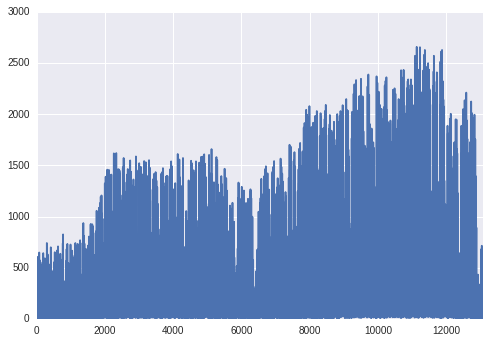

In [88]:
train_df.subscribed.plot();

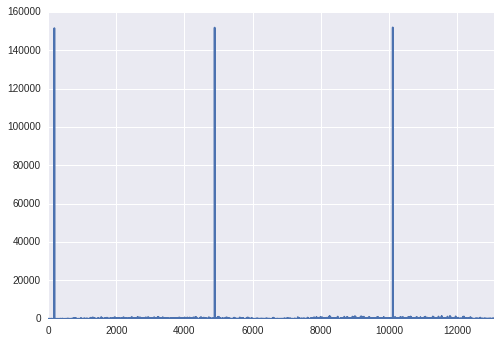

In [86]:
train_df.casual.plot()

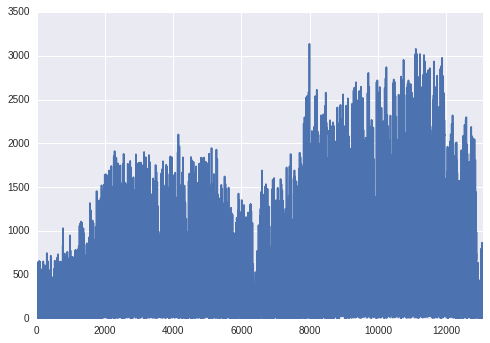

In [89]:
train_df.usage[train_df.casual < 1200].plot();

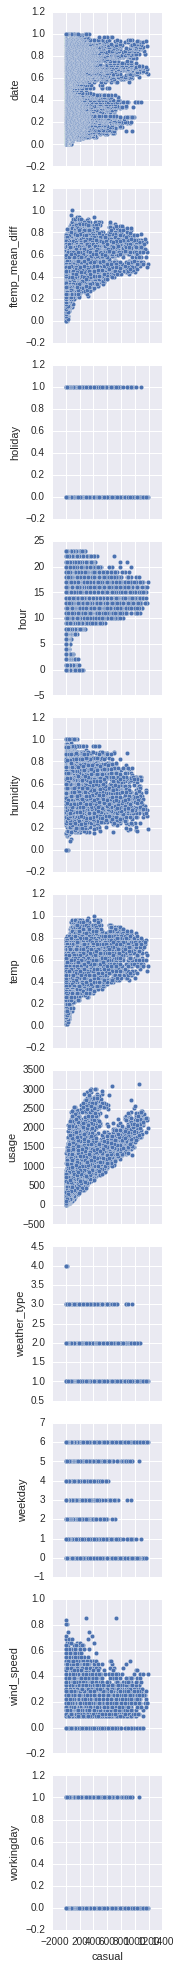

In [90]:
sns.pairplot(train_casual_df,\
             y_vars=train_casual_df.columns.difference(['subscribed','casual','ftemp']),\
             x_vars=['casual']);
savefig('scatter_casual.png',dpi=300)

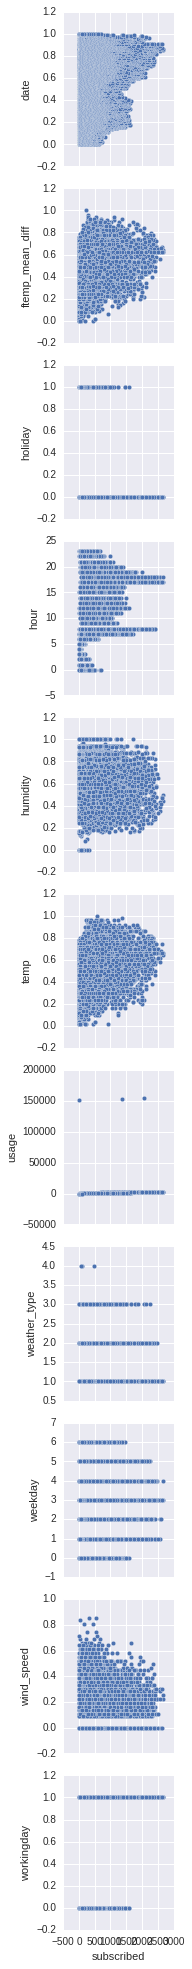

In [91]:
sns.pairplot(train_subscribed_df,\
             y_vars=train_subscribed_df.columns.difference(['subscribed','casual','ftemp']),\
             x_vars=['subscribed']);
savefig('scatter_subscribed.png',dpi=300)

# 4. Prediction

In [ ]:
casual_clf = KNeighborsRegressor(n_neighbors=2)
casual_clf.fit(X_casual_train,y_casual_train)
subscribed_clf = KNeighborsRegressor(n_neighbors=18)
subscribed_clf.fit(X_subscribed_train,y_subscribed_train)

In [ ]:
test_df = pd.read_csv('test.csv',parse_dates=["date"])
test_df.head()

In [ ]:
test_df["date"] = date_scaler.transform(test_df.date.astype(int)[:,newaxis])

In [ ]:
test_df["ftemp_mean_diff"] = test_df.ftemp
test_df.loc[test_df.ftemp == '-', 'ftemp_mean_diff'] = test_df.temp - ftemp_mean_dif
test_df["ftemp_mean_diff"] = test_df.ftemp_mean_diff.astype(float)

In [ ]:
test_df.head()

In [ ]:
X_test = scipy.hstack((test_df[["date","temp","ftemp_mean_diff","humidity","wind_speed"]].as_matrix(),\
                       pd.concat([test_df.hour.astype(int8),\
                                  test_df.holiday,\
                                  test_df.workingday,\
                                  test_df.weekday.astype(int8)\
                                 ],axis=1).as_matrix()))

In [ ]:
res = scipy.hstack([test_df.Id.as_matrix()[:,newaxis],\
                    (casual_clf.predict(X_test) + subscribed_clf.predict(X_test))[:,newaxis]])

In [ ]:
res_df = pd.DataFrame(data=res,columns=['Id','Expected'])
res_df.Id = res_df.Id.astype(int)
res_df.head()

In [ ]:
res_df.to_csv('submission.csv',index=False)